# 문제 정의
- 현재 주어진 과제의 경우에는 기본적인 이미지 분류 문제로, 주어진 이미지의 개수는 2000장을 넘지는 않지만, 클래스 별 분포를 확인 할 경우 과도한 불균형을 이루지 않기 때문에 추가적인 작업을 진행하지 않았다. 

# 진행 방향과 모델 선택
- 학습을 위한 모델은 이미지 분류에서 높은 성능을 보여운 efficientNet을 사용하였고, B0, B3, B7 모델을 사용하여 성능을 확인하였다. 

- 약 1700장의 이미지를 사용하기 때문에 augmentation으로는 Randaugment를 사용하여 다양하고 확률적으로 augmentation을 하도록 진행하였다.

- 데이터가 과도하게 불균형으로 분포 되어 있지는 않지만, 불균형 데이터를 해결하기 위해 StratifiedKFold를 사용하여 모델을 학습하였다.

- 모델 성능 평가에는 F1-score를 사용하였다.

# 예측 및 결과
- StratifiedKFold를 통해 나온 모델에 대해서 예측을 하였고, 이들의 평균값으로 최종 label를 예측하였다. 그 결과 efficientB7의 모델이 가장 높은 성능을 보였다.

In [1]:
!nvidia-smi

Sun May 23 04:53:08 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# train, test 압축 풀기
# import zipfile
         
# fantasy_zip = zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/program/test.zip')
# fantasy_zip.extractall('/content/drive/MyDrive/Colab Notebooks/program')
 
# fantasy_zip.close()

In [3]:
#필요 라이브러리 설치
# !pip install git+https://github.com/ildoonet/pytorch-randaugment
# !pip install timm 

In [4]:
import os
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.optim import Adam, SGD
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import autocast, GradScaler

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.metrics import f1_score

import cv2
import timm
from tqdm import tqdm

from RandAugment import RandAugment

# Data

In [5]:
#train dataframe 생성

df = pd.DataFrame( columns = ['path','class'])                                    #dataframe 생성

path_dir = '/content/drive/MyDrive/Colab Notebooks/program'                       #현재 작업 위치 및 파일 위치

count = 0
for i in (os.listdir(path_dir + '/train')):                                       # train 폴더 안의 클래스 별
  for j in (os.listdir(path_dir + '/train' + '/' + i)):                           # 클래스 별 사진 
    new_data = {'path': path_dir + '/train' + '/' + i + '/' + j,                        # 사진 path , class 지정
                'class' : str(count)
                }
    # df['path'] = path_dir + '/train' + '/' + str(i) + j
    # df['class'] = count 
    df = df.append(new_data, ignore_index= True)    
  count += 1

df.sample(5)                                                                      # dataframe sample 확인

,path,class
875,/content/drive/MyDrive/Colab Notebooks/program...,3
1062,/content/drive/MyDrive/Colab Notebooks/program...,5
1483,/content/drive/MyDrive/Colab Notebooks/program...,6
1035,/content/drive/MyDrive/Colab Notebooks/program...,4
616,/content/drive/MyDrive/Colab Notebooks/program...,2


In [6]:
#one hot vetor 변환
data = df.copy()                                                                  # df copy
train = pd.concat([data,pd.get_dummies(data['class']) ],axis = 1)                 # one hot vetor 열 생성
train.sample(5)                                                                   # sample 확인

,path,class,0,1,2,3,4,5,6
609,/content/drive/MyDrive/Colab Notebooks/program...,2,0,0,1,0,0,0,0
616,/content/drive/MyDrive/Colab Notebooks/program...,2,0,0,1,0,0,0,0
249,/content/drive/MyDrive/Colab Notebooks/program...,0,1,0,0,0,0,0,0
655,/content/drive/MyDrive/Colab Notebooks/program...,2,0,0,1,0,0,0,0
683,/content/drive/MyDrive/Colab Notebooks/program...,2,0,0,1,0,0,0,0


In [7]:
#fold 생성
# train = df.copy()
Fold = StratifiedKFold(n_splits=5)                                                # N fold  

groups = train['class'].values
for n, (train_index, val_index) in enumerate(Fold.split(train, train['class'], groups)):
    train.loc[val_index, 'fold'] = int(n)

train['fold'] = train['fold'].astype(int)
train['class'] = train['class'].astype(int)
print(train.groupby('fold').size())                                               # fold별 size 확인
print(train.sample(5))                                                            # data 확인

fold
0    340
1    340
2    340
3    339
4    339
dtype: int64
                                                   path  class  0  ...  5  6  fold
1045  /content/drive/MyDrive/Colab Notebooks/program...      4  0  ...  0  0     4
644   /content/drive/MyDrive/Colab Notebooks/program...      2  0  ...  0  0     2
804   /content/drive/MyDrive/Colab Notebooks/program...      3  0  ...  0  0     1
992   /content/drive/MyDrive/Colab Notebooks/program...      4  0  ...  0  0     2
350   /content/drive/MyDrive/Colab Notebooks/program...      1  0  ...  0  0     0

[5 rows x 10 columns]


# Data 분포

In [30]:
data_value_count = train['class'].value_counts().sort_index()
data_value_count

0    329
1    205
2    235
3    134
4    151
5    245
6    399
Name: class, dtype: int64

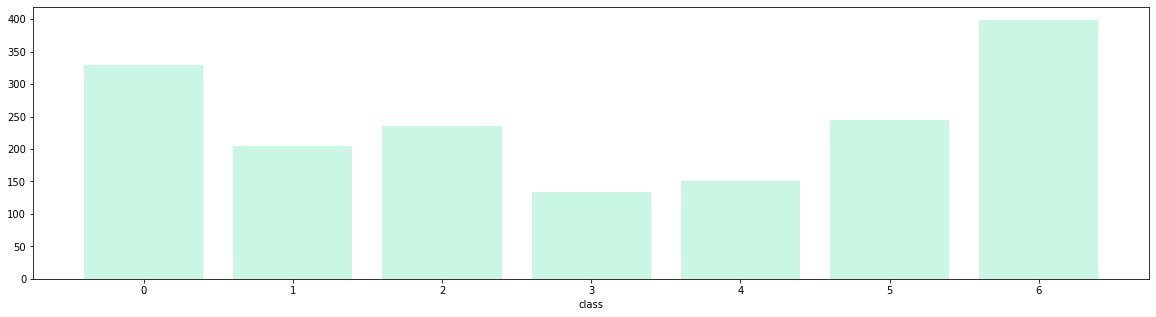

In [27]:
data_value_count = train['class'].value_counts().sort_index()
data_value_list=np.sort(train['class'].unique())
color =['#caf7e3','#caf7e3','#caf7e3','#caf7e3','#caf7e3','#caf7e3','#caf7e3']
plt.figure(figsize=(20,5))
plt.bar(data_value_list,data_value_count,color=color)
plt.xticks(data_value_list)
plt.xlabel('class')
plt.show()

# CFG

In [8]:
class CFG:
    debug=False
    print_freq=100
    num_workers=2
    model_name='eff_b7'
    size=227
    scheduler='ReduceLROnPlateau' # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts']
    epochs=25
    factor=0.5 # ReduceLROnPlateau
    patience=3 # ReduceLROnPlateau
    eps=1e-6 # ReduceLROnPlateau
    # T_max=6 # CosineAnnealingLR
    #T_0=6 # CosineAnnealingWarmRestarts
    lr=1e-4
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps= 1
    max_grad_norm=1000
    seed=42
    target_size= 7
    target_cols=['0','1','2','3','4','5','6']
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4]
    train=True
    
OUTPUT_DIR ='./output/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [9]:
# GPU 할당확인 

print('CUDA GPU availalbe : {}'.format(torch.cuda.is_available()))
try:
    print('{} GPU(s) is(are) allocated'.format(torch.cuda.device_count()))
except:
    print('GPUs are not allocated. Current runtime is on CPU.')

CUDA GPU availalbe : True
1 GPU(s) is(are) allocated


In [10]:
#f1 score 계산하기
def get_score(y_true, y_pred): 
    scores = []
    for i in range(y_true.shape[1]):
        score = f1_score(y_true[:,i], y_pred[:,i] > 0.5,average='macro')
        scores.append(score)
    avg_score = np.mean(scores)
    return avg_score, scores

In [31]:
# seed 고정
def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed= CFG.seed)

#Data set

In [12]:
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df =  df
        self.labels = df[CFG.target_cols].values                
        self.transform = transform
        
    def __getitem__(self, idx):           
        image = Image.open(self.df.loc[idx]['path'])            
        label = torch.tensor(self.labels[idx]).float()

        if self.transform:            
            
            image = self.transform(image)

        return image, label
        
    def __len__(self):        
        return len(self.df)

#Transforms

In [13]:
def get_transforms(*, data):
    if data == 'train':
        return transforms.Compose([                                      
                                      RandAugment(2,15),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
     

    elif data == 'valid':
        return transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
    
    elif data == 'test':
        return transforms.Compose([                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ])
     
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([227, 227, 3])


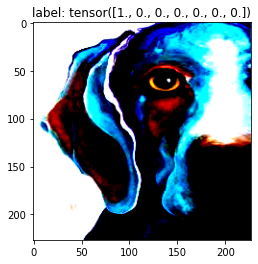

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([227, 227, 3])


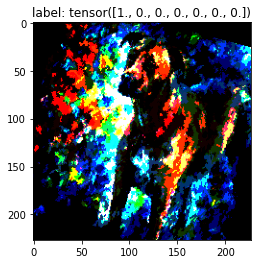

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([227, 227, 3])


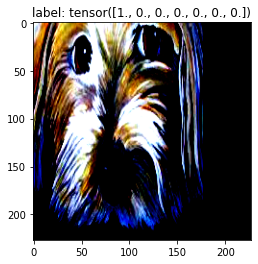

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([227, 227, 3])


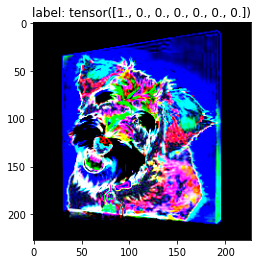

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([227, 227, 3])


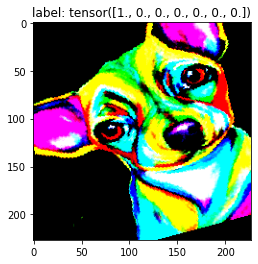

In [14]:
#Transfrom 확인

train_dataset = TrainDataset(train, transform=get_transforms(data='train'))

for i in range(5):
    image, label = train_dataset[i]
    image= np.transpose(image,(1,2,0))
    plt.imshow(image)
    plt.title(f'label: {label}')
    print(image.shape)
    plt.show() 

# Model

In [15]:
class Custom_model(nn.Module):
    def __init__(self, pretrained=False):
        super().__init__()
        self.model = timm.create_model('tf_efficientnet_b7_ns', pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, 7)

    def forward(self, x):
        x = self.model(x)
        return x

# Function

In [16]:
class AverageMeter(object):    
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count




def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device):
    scaler = GradScaler()    
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()    
    global_step = 0
    
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
       
        images = images.to(device)
        labels = labels.to(device)        
        batch_size = labels.size(0)
       
        with autocast():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        # record loss
        losses.update(loss.item(), batch_size)
        
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        scaler.scale(loss).backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            
                
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '  
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  # 'LR: {lr:.6f}  '
                  .format(
                   epoch+1, step, len(train_loader),loss=losses,                   
                   grad_norm=grad_norm,
                  #  lr=scheduler.get_lr()[0],
                   ))
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):    
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
            
        
        
        
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '                 
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(
                   step, len(valid_loader), loss=losses,
                   
                   ))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [17]:
def train_loop(folds, fold):
    print("=" *100)
    print(f"============================== fold: {fold} training ==============================")
    print("=" *100)

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[CFG.target_cols].values

    train_dataset = TrainDataset(train_folds, 
                                 transform=get_transforms(data='train'))
    valid_dataset = TrainDataset(valid_folds, 
                                 transform=get_transforms(data='valid'))

    train_loader = DataLoader(train_dataset, 
                              batch_size=CFG.batch_size, 
                              shuffle=True, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset, 
                              batch_size=CFG.batch_size * 2, 
                              shuffle=False, 
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)
    
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps)
        elif CFG.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = Custom_model(pretrained=True)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
#     optimizer = AdamP(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay)
    
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
#     criterion = nn.CrossEntropyLoss()
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(CFG.epochs):
        
        
        
        # train
        avg_loss = train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score, scores = get_score(valid_labels, preds)

        

        print(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}'  )
        print(f'Epoch {epoch+1} - Score: {score:.4f}  Scores: {np.round(scores, decimals=4)}')
        print("=" *100)

        
        if score > best_score:
            best_score = score
            print(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            print("=" *100)
            print("=" *100)
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        
        
#         if avg_val_loss < best_loss:
#             best_loss = avg_val_loss
#             print(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
#             print("=" *100)
#             print("=" *100)
#             torch.save({'model': model.state_dict(), 
#                         'preds': preds},
#                         OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
        
    # 학습 진행하고 예측한 Valid의 값을 return  
    check_point = torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth')
    for c in [f'pred_{c}' for c in CFG.target_cols]:
        valid_folds[c] = np.nan
    valid_folds[[f'pred_{c}' for c in CFG.target_cols]] = check_point['preds']

    return valid_folds

In [18]:
def main():
   
    def get_result(result_df):
        preds = result_df[[f'pred_{c}' for c in CFG.target_cols]].values
        labels = result_df[CFG.target_cols].values
        score, scores = get_score(labels, preds)
        print(f'Score: {score:<.4f}  Scores: {np.round(scores, decimals=4)}')
    
    if CFG.train:
        # train 
        # train_loop에서 return 받은 valid_folds 값들을 dataframe에 concat
        # valid set 예측 값이 모인 dataframe에 대해서 f1 score 계산
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                print(f"========================= fold: {fold} result =========================")
                get_result(_oof_df)
        # CV result
        print(f"========================= CV =========================")
        get_result(oof_df)
        # save result
        # oof_df.to_csv(OUTPUT_DIR+'oof_df.csv', index=False)

In [19]:
if __name__ == '__main__':
    main()

============================== fold: 0 training ==============================


Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b7_ns-1dbc32de.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b7_ns-1dbc32de.pth


Epoch: [1][0/42] Loss: 0.6989(0.6989) Grad: 51915.9531  
Epoch: [1][41/42] Loss: 0.3107(0.4795) Grad: 40002.9766  
EVAL: [0/6] Loss: 0.2175(0.2175) 
EVAL: [5/6] Loss: 0.2295(0.2838) 
Epoch 1 - avg_train_loss: 0.4795  avg_val_loss: 0.2838
Epoch 1 - Score: 0.6860  Scores: [0.8692 0.6546 0.8191 0.4793 0.4769 0.7315 0.7713]
Epoch 1 - Save Best Score: 0.6860 Model
Epoch: [2][0/42] Loss: 0.2881(0.2881) Grad: 44352.0781  
Epoch: [2][41/42] Loss: 0.1407(0.1885) Grad: 59068.3281  
EVAL: [0/6] Loss: 0.0906(0.0906) 
EVAL: [5/6] Loss: 0.0535(0.0870) 
Epoch 2 - avg_train_loss: 0.1885  avg_val_loss: 0.0870
Epoch 2 - Score: 0.9536  Scores: [0.9812 0.9499 0.9813 0.9352 0.8834 0.9689 0.9755]
Epoch 2 - Save Best Score: 0.9536 Model
Epoch: [3][0/42] Loss: 0.0983(0.0983) Grad: 40329.7969  
Epoch: [3][41/42] Loss: 0.1022(0.0868) Grad: 46318.3789  
EVAL: [0/6] Loss: 0.0526(0.0526) 
EVAL: [5/6] Loss: 0.0233(0.0494) 
Epoch 3 - avg_train_loss: 0.0868  avg_val_loss: 0.0494
Epoch 3 - Score: 0.9770  Scores: [0.97

# Test Dataset

In [20]:
class TestDataset(Dataset):
    def __init__(self,df,transform=None):
        self.df = df        
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):   
        image = Image.open(self.df.loc[idx]['path'])  
        
        if self.transform:            
            image = self.transform(image)
        return image

In [21]:
#fold 별 모델에서 나온 결과를 평균 값 return
def inference(model, states, test_loader, device):
    model.to(device)
    data = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in data:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state['model'])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.sigmoid().to('cpu').numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

In [22]:
#test dataframe 생성

df_test = pd.DataFrame( columns = ['path','answer value'])                                    #dataframe 생성

path_dir = '/content/drive/MyDrive/Colab Notebooks/program'                       #현재 작업 위치 및 파일 위치

count = 0
for i in (os.listdir(path_dir + '/test')):                                        # train 폴더 안의 클래스 별
  for j in (os.listdir(path_dir + '/test' + '/' + i)):                           # 클래스 별 사진 
    new_data = {'path': path_dir + '/test' + '/' + i + '/' + j                   # 사진 path , class 지정
                }
    # df['path'] = path_dir + '/train' + '/' + str(i) + j
    # df['class'] = count 
    df_test = df_test.append(new_data, ignore_index= True)   
  

df_test.sample(5)                                                                      # dataframe sample 확인

,path,answer value
157,/content/drive/MyDrive/Colab Notebooks/program...,NaN
341,/content/drive/MyDrive/Colab Notebooks/program...,NaN
315,/content/drive/MyDrive/Colab Notebooks/program...,NaN
234,/content/drive/MyDrive/Colab Notebooks/program...,NaN
155,/content/drive/MyDrive/Colab Notebooks/program...,NaN


In [23]:
model = Custom_model(pretrained=False)
#fold 별 학습시킨 모든 모델 불러오기
states = [torch.load(OUTPUT_DIR+f'{CFG.model_name}_fold{fold}_best.pth') for fold in CFG.trn_fold]

test_dataset = TestDataset(df_test,transform=get_transforms(data='test'))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, 
                         num_workers=CFG.num_workers, pin_memory=True)

predictions = inference(model, states, test_loader, device)

100%|██████████| 11/11 [00:27<00:00,  2.45s/it]


In [24]:
# submission
df_test[CFG.target_cols] = predictions
df_test[['path'] + CFG.target_cols]
df_test.head()

,path,answer value,0,1,2,3,4,5,6
0,/content/drive/MyDrive/Colab Notebooks/program...,NaN,0.007407,0.000020,0.973979,0.000026,0.000027,0.000034,0.002851
1,/content/drive/MyDrive/Colab Notebooks/program...,NaN,0.000168,0.000271,0.000121,0.999892,0.000176,0.000128,0.000147
2,/content/drive/MyDrive/Colab Notebooks/program...,NaN,0.000613,0.000122,0.000076,0.999918,0.000167,0.000073,0.000068
3,/content/drive/MyDrive/Colab Notebooks/program...,NaN,0.000082,0.000065,0.434729,0.505588,0.000408,0.000059,0.000065
4,/content/drive/MyDrive/Colab Notebooks/program...,NaN,0.001642,0.000030,0.000053,0.988393,0.006131,0.000030,0.001232


In [25]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/program/test_answer_sample_.csv')
total_test = df_test.iloc[:,2:]
submission['answer value'] = total_test.idxmax(axis=1)
submission.to_csv(OUTPUT_DIR+'submission.csv', index=False)
submission.head()

,Unnamed: 0,answer value
0,0,2
1,1,3
2,2,3
3,3,3
4,4,3
